In [1]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
    fit_uncertainties_and_remove_outliers,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from sklearn.decomposition import TruncatedSVD

/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_rot_kernel(V_sin_i, wl, W_conv):
/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_s

In [15]:
from POSEIDON.utility import read_high_res_data
import h5py

data = h5py.File("./data/WASP-121b.h5", "a")

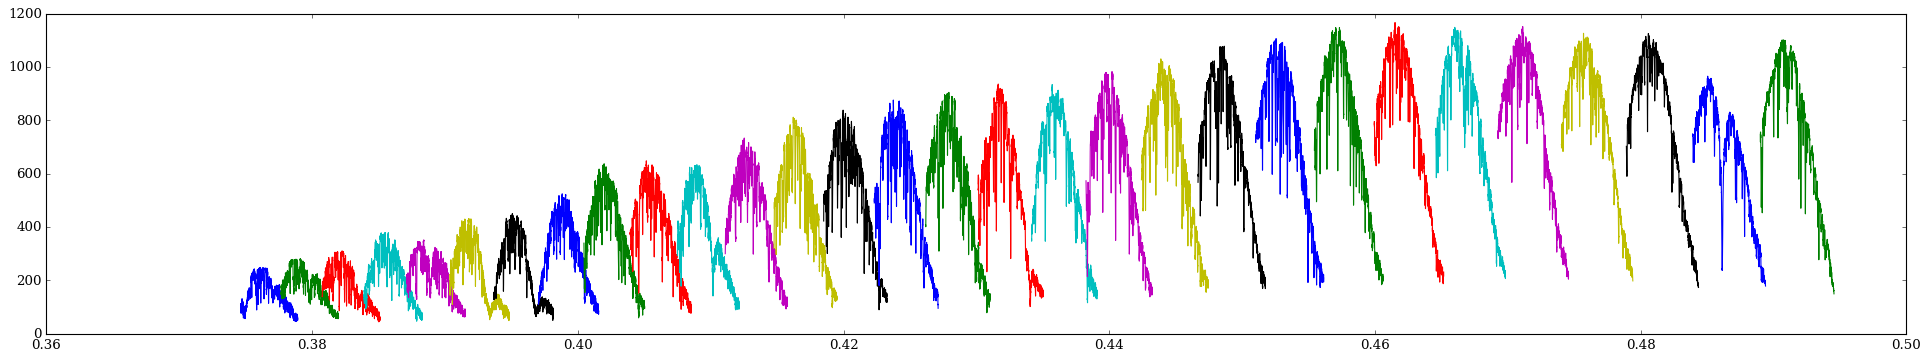

In [4]:
plt.figure(figsize=(30, 5))
# plt.plot(data["redl/wl_grid"][20], np.mean(data["redl/uncertainties"][20], axis=0))
for order_i in range(len(data["blue/wl_grid"])):
    plt.plot(
        data["blue/wl_grid"][order_i],
        np.mean(data["blue/flux_blaze_corrected"][order_i], axis=0),
    )

In [5]:
# The code below will only be run on one core to get the model spectrum.
# if __name__ == "__main__":
R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effectsive temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "Fe -6"  # Model name used for plots, output files etc.
bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere

In [6]:
# for species in ["Fe", "Li", "Mg", "Ti"]:
species = "Fe"
param_species = [species]

model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm")
# cloud_model="MacMad17", cloud_type="deck")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um) 0.37
wl_max = 0.87  # Maximum wavelength (um) 1.05
R = 250000  # Spectral resolution of grid
model["R"] = R
model["R_instrument"] = 66000  # Resolution of instrument

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 2e-2  # Reference pressure (bar)
R_p_ref = 1.8 * R_J  # Radius at reference pressure

params = (-6, 3000)
log_species, T = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_species]])
cloud_params = np.array([[np.log10(0.05)]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

Free parameters: ['R_p_ref' 'T' 'log_Fe']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [16]:
from scipy.optimize import minimize
from MAROON.Recipes import LoadNight
from MAROON.Constants import Rsun, Rjup, au
from MAROON import Recipes
from MAROON import Constants
from MAROON.Recipes import *

nights = []
for arm in ["redu", "blue", "redl"]:
    night = LoadNight(empty=True)
    night.Kp_0 = 196.52  # Ehrenreich+2020 (km/s)
    night.Vsys_0 = -1.16  # Ehrenreich+2020 (km/s)
    night.kRV = 116  # Ehrenreich+2020 (m/s)
    night.tt = 2448.89524293553 + 2457000  # TESS
    night.per = 1.8098956637628 * 24 * 3600  # TESS
    night.Rstar = 1.756 * Rsun  # Ehrenreich+2020
    night.Rp = 1.854 * Rjup  # Ehrenreich+2020
    night.b = 0.027  # Ehrenreich+2020
    night.ap = 0.033 * au  # Ehrenreich+2020
    night.wave = data["{}/wl_grid".format(arm)][:]
    night.counts_start = data["{}/flux".format(arm)][:].transpose(1, 0, 2)
    night.nexposures = night.counts_start.shape[0]
    night.norders = night.counts_start.shape[1]
    night.npixels = night.counts_start.shape[2]
    night.orders = np.arange(night.norders)
    night.planet_phases = data["{}/phi".format(arm)][:]
    night.calc_transit_properties()
    night.discard_bad_data()
    counts_start_corrected = night.correct_bad_pixels(flux=night.counts_start, sigma=5)

    noise_model = night.get_noise_model(counts_start_corrected)
    night.build_regions_mask([])

    RV = calc_Vcirc_from_phase(Kp=night.Kp_0, phases=night.planet_phases)
    night.planet_vels = RV
    night.net_pla_shifts = night.planet_vels + night.Vsys_0

    night.star_vels = (
        calc_Vcirc_from_phase(Kp=-night.kRV, phases=night.planet_phases) / 1000
    )  # km/s

    # align spectra to common continuum - à la Gibson et al. 2022 (box width - 501, Gaussian width = 100)
    preped_flux = night.spec_alignment(
        flux=counts_start_corrected * 1,
        spectrum_alignment="hpf",
        box_width=21,
        gaussian_width=50,
        keep_steps=True,
    )
    # preped_flux = night.spec_alignment(flux=counts_start_corrected*1, spectrum_alignment='hpf', box_width=501, gaussian_width=100, keep_steps=True)
    # clean data (fit out-of-transit spectrum and apply PCA, remove 10 components in this case)
    night.flux = night.process_data(
        preped_flux * 1.0,
        Npcs_removed=10,
        keep_steps=True,
        sigmas=noise_model,
        Print=True,
    )
    # update orders in case
    night.update_orders(night.flux)
    # rebuilt transmission model (what has been removed from the data - this is in what we will inject models in for retrievals)
    RebuiltTransmission = preped_flux / night.flux
    # uncertainty at every pixel
    sigmas = noise_model / RebuiltTransmission
    night.sigmas = sigmas
    night.instr_resolution = 85000
    # define velocity grids for cross-correlation
    RVs = np.arange(-400, 401, 1)
    Kp_range = np.arange(-300, 301, 1)
    Vsys_range = np.arange(-100, 101, 1)

    night.Vsys_range = Vsys_range
    night.Kp_range = Kp_range
    model_wave, model_flux = wl, spectrum
    prepd_model_flux = model_flux
    # model_wave, prepd_model_flux = BroadenSpec(
    #     wave=model_wave,
    #     flux=model_flux,
    #     end_resolution=night.instr_resolution,
    #     Print=True,
    # )
    # Cross-correlate data with model(s) for each order, exposure, and RV shift
    CCF_mat = night.CCF(
        fluxes=night.flux,
        pla_mod_wave=model_wave,
        pla_mod_flux=prepd_model_flux,
        sigmas=night.sigmas,
        Planet_RVs=RVs,
    )
    # build a mask to block out a region in RV space of width = 10 km/s centered on Vsys (to mask out RM effect)
    night.calc_CCF_mask(RM_mask=10, RM_center=0)
    # phase-fold CCF matrix to compute SNR maps, weigh exposures by transit model
    night.calc_SNRmap(
        CCF_mat=CCF_mat, exposure_weights=night.exposure_weights, box_half_width=40
    )

    night.reduction_steps.append(night.sigmas)
    night.CCF_mat = CCF_mat
    nights.append(night)

Fitting out median spectrum from each exposure
Total number of big segments = 1
Total number of outliers = 127
Fitting noise model
Bringing all specs to a common continuum
Double High Pass took 0.262 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components
Masking >4 sigma standard deviation columns (340 columns total (0.6% of the data)).
Calculated Model Resolution = 249999.0 --> Downgrading to R = 85000
Starting Cross-Correlation
Cross-Correlation: took 0.998 minutes
Applying mask 10km/s mask centered at 0km/s
Fitting out median spectrum from each exposure
Total number of big segments = 2
Total number of outliers = 226
Fitting noise model
Bringing all specs to a common continuum
Double High Pass took 0.275 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components
Masking >4 sigma standard deviation columns (265 columns total (0.4% of the data)).
Calculated Model Resolution = 249999.0 --> Downgrading to R = 85000
Sta

Applying mask 10km/s mask centered at 0km/s


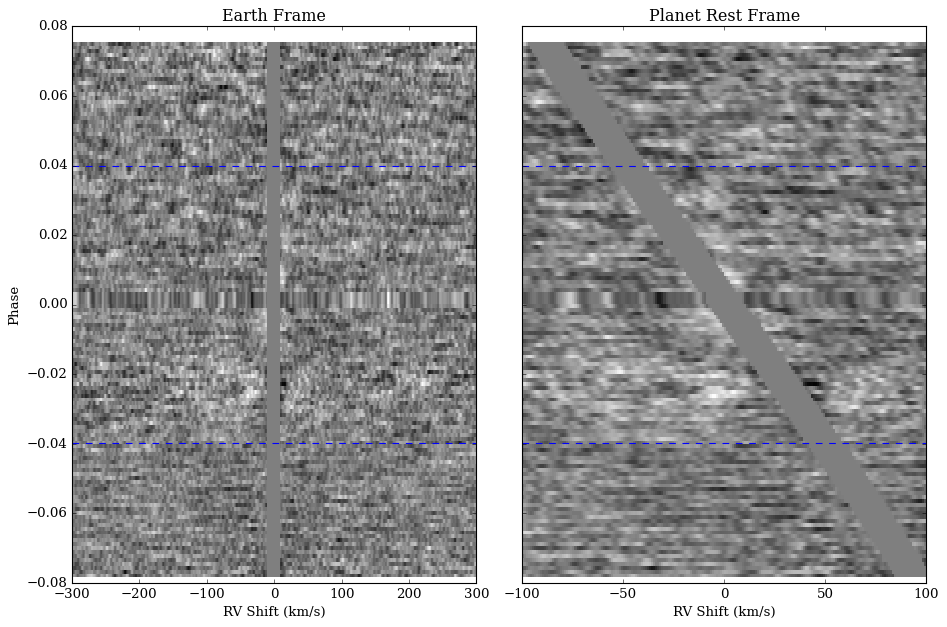

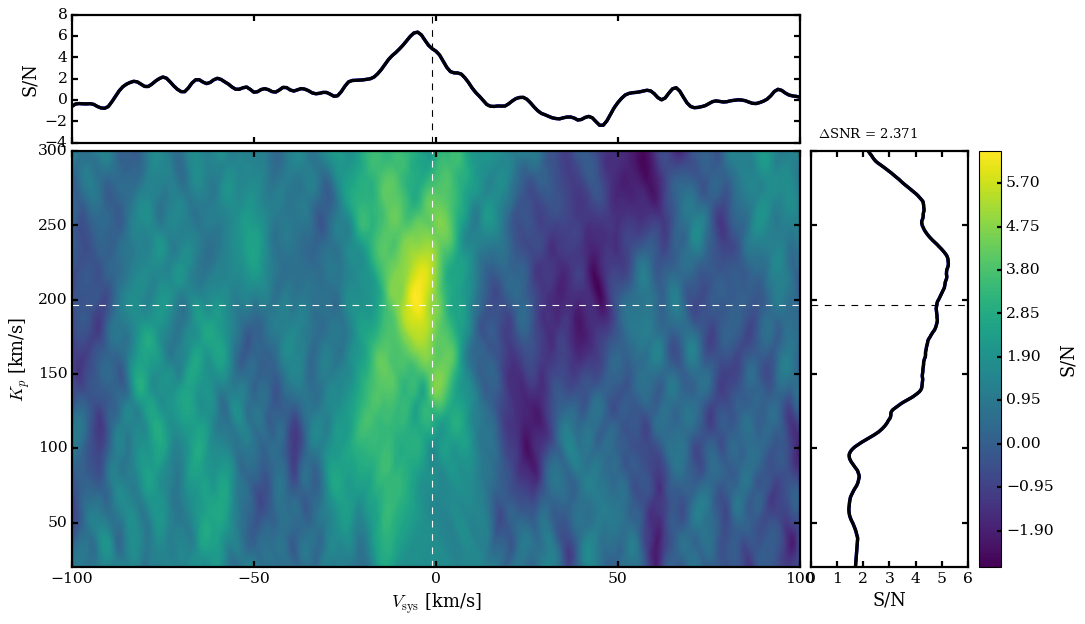

In [ ]:
phase_grid = Recipes.gen_common_phase_grid(nights)
# interpolate each night on this phase grid
ni = Recipes.combine_nights(nights, phase_grid)
plotting = True
if plotting:
    ni.plotCCOrbit2(
        ni.SummedCCF_mat[0],
        xlim=[-300, 300],
        apply_CCF_mask=True,
    )
    ni.plotKpVsys(
        ni.SNRmapCCF[0],
        ylim=[20, None],
    )

In [9]:
# for chip in ["redl", "redu", "blue"]:
#     flux = data[chip]["flux"][:]
#     N_order, N_phi, N_wl = flux.shape
#     continuum = np.zeros((N_order, N_phi, N_wl))
#     for k in range(N_order):
#         order = flux[k]
#         middle = np.median(order, axis=0)
#         order_norm = order / middle

#         continuum[k] = order_norm

#     for det in range(N_order):
#         for phi in range(N_phi):
#             continuum[det][phi] = median_filter(continuum[det][phi], size=501)

#     for det in range(N_order):
#         for phi in range(N_phi):
#             continuum[det][phi] = gaussian_filter1d(continuum[det][phi], sigma=100)

#     flux_blaze_corrected = flux / continuum

#     data[chip]["flux_blaze_corrected"][:] = flux_blaze_corrected

In [10]:
# for chip in ["redl", "redu", "blue"]:
data = h5py.File("./data/WASP-121b.h5", "a")
for chip in ["blue"]:
    flux = data[chip]["flux_blaze_corrected"][:]
    N_order, N_phi, N_wl = flux.shape
    uncertainties = fit_uncertainties(flux)

    for i in range(N_order):
        uncertainties[i] = uncertainties[i] / np.median(flux[i], axis=0)
        flux[i] = flux[i] / np.median(flux[i], axis=0)
        mean = np.mean(flux[i], axis=-1)[:, None]
        pca = TruncatedSVD(n_components=10).fit((flux[i] - mean).T)
        PCAs = (pca.transform((flux[i] - mean).T) @ pca.components_).T + mean
        uncertainties[i] = uncertainties[i] / PCAs
        flux[i] = flux[i] / PCAs

    residuals = flux - np.mean(flux, axis=2)[:, :, None]
    # for i in range(N_order):
    #     order = flux[i]
    #     # out_of_transit_frames = np.concatenate((order[:30], order[-30:]), axis=0)
    #     median = np.median(order, axis=0)
    #     order_norm = order / median
    #     uncertainty = uncertainties[i]
    #     uncertainty_norm = uncertainty / median
    #     uncertainties[i] = uncertainty_norm
    #     flux[i] = order_norm

    # residuals, Us = fast_filter(flux, uncertainties, N_iter=15)

    # Bs = np.zeros((N_order, N_phi, N_phi))

    # for j in range(N_order):
    #     U = Us[j]
    #     L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    #     B = U @ np.linalg.pinv(L @ U) @ L
    #     Bs[j] = B

    data[chip].require_dataset("residuals", shape=residuals.shape, dtype=float)
    data[chip]["residuals"][:] = residuals
    # data[chip].require_dataset("Bs", shape=Bs.shape, dtype=float)
    # data[chip]["Bs"][:] = Bs
    data[chip].require_dataset("uncertainties", shape=uncertainties.shape, dtype=float)
    data[chip]["uncertainties"][:] = uncertainties
data.close()

0.09578934349213707 256.1604414865158
0.3413425364302509 244.97402140674484
0.020756449912944085 303.9708589042999
0.2615798309384865 275.08047856971075
0.27881787896003163 271.98003901194096
0.23181885923115056 281.4931577183359
0.255037119169372 283.0561132285653
0.31302727917452694 274.93887338080276
0.34258073474630135 270.3948852537491
0.3301711954622533 276.18295339519466
0.2976478689786511 282.0101366723916
0.36311134340043816 257.58265038055185
0.31216146554830687 281.3238946297136
0.30914353025642066 280.7799986371345
0.2957101242986585 285.25349411980994
0.30779802207868695 278.5049925741469
0.30880022739194396 277.32163774153355
0.28026425057370197 294.41510800328774
0.27015414875244015 303.08907600914415
0.2699813610805313 300.4985529854554
0.28245197111003095 291.8019918434536
0.277638755777031 295.817729308981
0.2736075840029657 298.87693277596
0.28080004801856406 294.4613871169239
0.28819519865826515 284.51788694865706
0.28959520102891045 283.05197231387126
0.30455929816

Traceback (most recent call last):
  File "/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_259538/671217553.py", line 6, in <module>
    uncertainties = fit_uncertainties(flux)
  File "/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py", line 582, in fit_uncertainties
  File "/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py", line 204, in fit
    self.fit_transform(X)
  File "/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py", line 224, in fit_transform
    X = self._validate_data(X, accept_sparse=["csr", "csc"], ensure_min_

In [14]:
# centering the uncertainties before PCA?
data.close()